# figures_draft2018a.ipynb

## Purpose
Produce figures and supplementary figures for project p17d.

## Dependencies
Python modules mentioned in next cell, inlcuding [climapy](https://github.com/grandey/climapy) ([doi:10.5281/zenodo.1053020](https://doi.org/10.5281/zenodo.1053020)) and [lib_draft2018a.py](https://github.com/grandey/p17d-sulphur-eas-eqm/blob/master/analysis_draft2018a/lib_draft2018a.py) 

## Data requirements
CESM output data, post-processed to time-series format.

## Author
Benjamin S. Grandey, 2018

In [1]:
! date

Wed Feb  7 17:43:45 +08 2018


In [2]:
import climapy
import lib_draft2018a
import ipywidgets
from IPython.display import display
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
import pandas as pd
from scipy import stats
import xarray as xr

# Print versions of dependencies
for package in [climapy, np, pd, xr]:
    try:
        print('{}.__version__ = {}'.format(package.__name__, package.__version__))
    except AttributeError:
        pass
print('lib_draft2018a.py is using {}'.format(lib_draft2018a.dependency_versions()))

climapy.__version__ = 0.1.0+b35937c
numpy.__version__ = 1.13.3
pandas.__version__ = 0.22.0
xarray.__version__ = 0.10.0
lib_draft2018a.py is using {'climapy': '0.1.0+b35937c', 'pandas': '0.22.0', 'xarray': '0.10.0'}


In [3]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 40  # reduce resolution of inline figures

In [4]:
# Initialise counters to keep track of figure numbers
figure_counter = 1  # main manuscript
supp_figure_counter = 1  # supplementary figures
other_figure_counter = 1  # other figures (not included in manuscript)

In [5]:
# Load dictionaries etc from lib_draft2018a
region_bounds_dict = lib_draft2018a.load_region_bounds_dict()
region_long_dict = lib_draft2018a.load_region_long_dict()
scenario_name_dict = lib_draft2018a.load_scenario_name_dict()
variable_long_dict = lib_draft2018a.load_variable_long_dict()
variable_symbol_dict = lib_draft2018a.load_variable_symbol_dict()
variable_units_dict = lib_draft2018a.load_variable_units_dict()

In [6]:
# Longitude and latitude data used later
# Load sample data
sample_data = lib_draft2018a.load_output().isel(year=0)
# Set sample data equal to one - here, we are just interested in lat-lon info
sample_data[:] = 1.
# Shift longitudes
sample_data = climapy.xr_shift_lon(sample_data, lon_min=-179)
# Longitude and latitude data
lon = sample_data['lon']
lat = sample_data['lat']
# Lower bound for first longitude bin (important for map)
lon0 = (lon[0] - (lon[1]-lon[0])/2.0).values
# Pseudo-lower bound for first latitude bin (used for stretching imshow)
lat0 = (lat[0] - (lat[1]-lat[0])/2.0).values

## Function to produce emissions bar chart

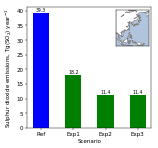

In [7]:
def emissions_bars(species='so2tot',
                   ylabel=r'Sulphur dioxide emissions, Tg(SO$_2$) year$^{-1}$',
                   ylim=None,
                   region='ESEAs',
                   map_inset=True,
                   ax=None):
    # Create Axes if no Axes passed as an argument
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    # Dataframe to hold regional totals
    data_df = pd.DataFrame(columns=('scenario', 'scenario_name', 'regional_total'))
    # Loop over scenarios
    for scenario in ['2000', 'eas0', 'eas0b', 'eas0c']:
        # Load emissions
        if species == 'so2tot':
            data = (lib_draft2018a.load_emissions(species='so2', surf_or_elev='both',
                                                  scenario=scenario, season='annual') +
                    lib_draft2018a.load_emissions(species='so4_a1', surf_or_elev='both',
                                                  scenario=scenario, season='annual') +
                    lib_draft2018a.load_emissions(species='so4_a2', surf_or_elev='both',
                                                  scenario=scenario, season='annual'))
        else:
            data = lib_draft2018a.load_emissions(species=species, surf_or_elev='both',
                                                 scenario=scenario, season='annual')
        # Calculate regional total
        lon_bounds, lat_bounds = region_bounds_dict[region]
        data = climapy.xr_area_weighted_stat(data, stat='sum', lon_bounds=lon_bounds,
                                             lat_bounds=lat_bounds).values / 1e12
        # Append to data_df
        data_df = data_df.append({'scenario': scenario, 
                                  'scenario_name': scenario_name_dict[scenario],
                                  'regional_total': data},
                                  ignore_index=True)
    # Plot bars
    ax.bar(data_df.index, data_df['regional_total'], width=0.5,
           color=['b', 'g', 'g', 'g'])
    # Axes
    ax.set_xticks(data_df.index)
    ax.set_xticklabels(data_df['scenario_name'])
    ax.set_xlabel('Scenario')
    ax.set_ylabel(ylabel)
    if ylim:
        ax.set_ylim(ylim)
    # Annotate with values
    for i in data_df.index:
        text = '{:.1f}'.format(data_df.loc[i, 'regional_total'])
        ax.text(i, data_df.loc[i, 'regional_total'],
                text, verticalalignment='bottom',
                horizontalalignment='center', fontsize='small')
    # Insert map
    if map_inset:
        ax2 = inset_axes(ax, width='30%', height='30%', loc=1,)
        ax2.set_facecolor('lightsteelblue')
        anchor = 'NE'
        if region == 'Globe':
            lon_bounds = [lon0, lon0+360.]
            lat_bounds = [-90.0, 90.0]
        else:
            lon_bounds, lat_bounds = region_bounds_dict[region]
        bm = Basemap(llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                     llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1],
                     anchor=anchor)
        bm.drawcoastlines(color='0.5')
        bm.fillcontinents(color='white')
    return ax

# Examples
if True:
    emissions_bars()

## Emissions bar chart composite figure

/Users/grandey/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Written local/f01.pdf


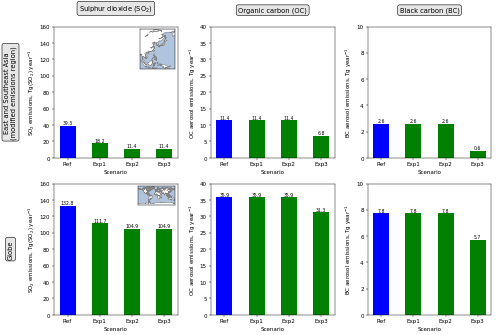

In [8]:
# Set up figure
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 3)
# Sulphur dioxide bar charts
species = 'so2tot'
ylabel = r'SO$_2$ emissions, Tg(SO$_2$) year$^{-1}$'
ylim = [0, 160]
ax1 = emissions_bars(species=species, ylabel=ylabel, ylim=ylim,
                     region='ESEAs', map_inset=True,
                     ax=plt.subplot(gs[0, 0]))
ax2 = emissions_bars(species=species, ylabel=ylabel, ylim=ylim,
                     region='Globe', map_inset=True,
                     ax=plt.subplot(gs[1, 0]))
# Organic carbon bar charts
species = 'oc'
ylabel = r'OC aerosol emissions, Tg year$^{-1}$'
ylim = [0, 40]
ax3 = emissions_bars(species=species, ylabel=ylabel, ylim=ylim,
                     region='ESEAs', map_inset=False,
                     ax=plt.subplot(gs[0, 1]))
ax4 = emissions_bars(species=species, ylabel=ylabel, ylim=ylim,
                     region='Globe', map_inset=False,
                     ax=plt.subplot(gs[1, 1]))
# Black carbon bar charts
species = 'bc'
ylabel = r'BC aerosol emissions, Tg year$^{-1}$'
ylim = [0, 10]
ax5 = emissions_bars(species=species, ylabel=ylabel, ylim=ylim,
                     region='ESEAs', map_inset=False,
                     ax=plt.subplot(gs[0, 2]))
ax6 = emissions_bars(species=species, ylabel=ylabel, ylim=ylim,
                     region='Globe', map_inset=False,
                     ax=plt.subplot(gs[1, 2]))
# Column titles
for ax, title in zip([ax1, ax3, ax5],
                     [r'Sulphur dioxide (SO$_2$)',
                      r'Organic carbon (OC)',
                      r'Black carbon (BC)']):
    ax.text(0.5, 1.1, title,
            transform=ax.transAxes, fontsize='large',
            verticalalignment='bottom', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Row titles
for ax, title in zip([ax1, ax2],
                     ['East and Southeast Asia\n(modified emissions region)',
                      'Globe']):
    ax.text(-0.35, 0.5, title,
            transform=ax.transAxes, fontsize='large', rotation=90,
            verticalalignment='center', horizontalalignment='center',
            bbox={'boxstyle': 'round, pad=0.3', 'fc': '0.9', 'ec': 'k'})
# Prevent overlapping labels
fig.tight_layout()
# Save figure
ofilename = 'local/f{:02}.pdf'.format(figure_counter)
fig.savefig(ofilename, bbox_inches='tight', dpi=300)
print('Written {}'.format(ofilename))
figure_counter += 1